In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# titanic data

Najpierw zaloguj się do https://www.kaggle.com/ i przejdź do wyzwania https://www.kaggle.com/c/titanic, aby pobrać 
 * train.csv i test.csv. 

Zapisz je w katalogu datasets/titanic.

In [2]:
import os

TITANIC_PATH = os.path.join("titanic")

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

* Dane są już podzielone na zestaw treningowy i zestaw testów. 
* Jednak dane testowe nie zawierają etykiet: Twoim celem jest wyszkolenie najlepszego modelu, który możesz wykorzystać w danych treningowych, następnie dokonanie swoich przewidywań na danych testowych i przesłanie ich do Kaggle, aby zobaczyć ostateczny wynik.

Rzućmy okiem na kilka pierwszych rzędów zestawu treningowego:

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic

# Zad
Sprawdzamy, czy mam jakieś missing data.

In [6]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Zad

Podzielmy atrybuty na część 
* objaśniającą $X$
* objaśnianą $y$

In [8]:
X = train_data.drop("Survived",axis=1)
y = train_data["Survived"]

# Zad 
Przyjrzyjmy się $y$. Musi to być kolumna numeryczna z labealmi.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (891, 11) y.shape: (891,)


# Zad
Podzielmy zbiór na train/test

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Zad

* Inaczej będziemy postępować z danymi: 
  * kategorycznymi, 
  * numerycznymi.
  
Wykorzystamy **DataframeSelector** aby wybrać określone atrybuty z DataFrame.

* since Scikit-Learn doesn't handle DataFrames yet

## Zaczniemy o dwybrania kolumn numerycznych

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names]

# Zad
Zbudujmy ostateczny **pipeline** dla atrybutów numerycznych:
* usuwa missing data 
```python
from sklearn.impute import SimpleImputer
```

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [13]:
# num_pipeline.fit_transform(X_train)

## Kolumny kategoryczne

# Zad
Zbudujmy **pipeline** dla atrybutów numerycznych:
* usuwa missing data 


In [14]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder
pipeline_3 = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [16]:
# pipeline_3.fit_transform(X_train)

# Zad
Narysuj heat mapę korelacji

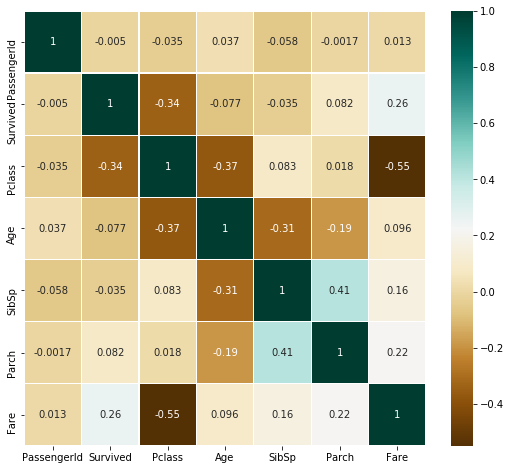

In [17]:
corr_matrix = train_data.corr()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9, 8))
sns.heatmap(data = corr_matrix,cmap='BrBG', annot=True, linewidths=0.2)
plt.show()


# Zad
Zbudujmy **pipeline** dla atrybutu 'Name'

* stwórz kolumnę zwierającą tytuł 
'Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'

* połącz odpowiednie atrybuty
* zamień tytuły na liczby

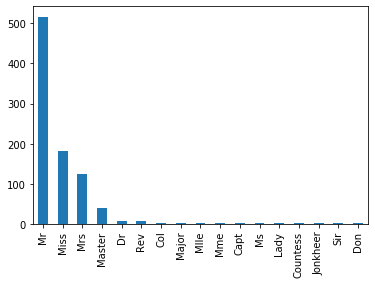

In [18]:
train_data['Title'] = train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_data.Title.value_counts().plot.bar()

Text(0, 0.5, 'Passenger count')

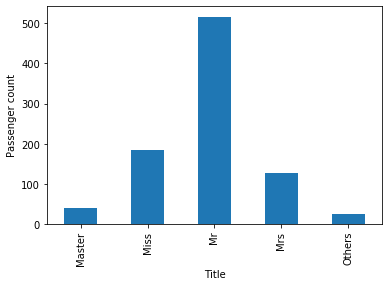

In [19]:
train_data['Title'] = train_data['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')
train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')

plt = train_data.Title.value_counts().sort_index().plot.bar()
plt.set_xlabel('Title')
plt.set_ylabel('Passenger count')

In [204]:
class TitleEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self, dictionary):
#         self.dictionary = dictionary
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X[X.columns[0]].str.extract(' ([A-Za-z]+)\.', expand=False)
        X = X.replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don', 'Master'], 'Others')
        X = X.replace('Ms', 'Miss')
        X = X.replace('Mme', 'Mrs')
        X = X.replace('Mlle', 'Miss')
        return np.vstack(X.values)#X.replace(self.dictionary).values

pipeline_5 = Pipeline([
        ("select_cat", DataFrameSelector(['Name'])),
        ("title_encoder", TitleEncoder()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

pipeline_5.fit_transform(X_train)

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [205]:
pipeline_5.transform(X_test)

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],


# Zad
Zbudujmy **pipeline** dla atrybutu 'Cabin'
* Zamień missing data na U
* Zamień pozostałe nazwy kabin na pierwszą literę nazwy
* zbuduj one hot encoing

In [206]:
# fill Cabin NaN with U for unknown
train_data.Cabin = train_data.Cabin.fillna('U')
train_data.Cabin = train_data.Cabin.map(lambda x: x[0])
# train_data.Cabin

In [207]:
class CabinEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self, dictionary):
#         self.dictionary = dictionary
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X
        X = X.fillna('U')
        X = X[X.columns[0]].map(lambda x: x[0])
        return np.vstack(X.values)#X.replace(self.dictionary).values

pipeline_6 = Pipeline([
        ("select_cat", DataFrameSelector(['Cabin'])),
        ("cabin_encoder", CabinEncoder()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ])

pipeline_6.fit_transform(X_train)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [208]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", pipeline_3),
        ("title_pipeline", pipeline_5),
        ("cabin_pipeline", pipeline_6),
    ])

In [209]:
# preprocess_pipeline.fit(X_train)

In [210]:
# preprocess_pipeline.transform(X_test).shape

# Zad

Robimy StratifiedKFold i znajdujemy optymalne parametry dla


* LogisticRegression
* LinearSVC
* SVC
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* BaggingClassifier
* ExtraTreesClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* VotingClassifier
* xgboost.XGBClassifier

In [211]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5)

In [212]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

pipe = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

{'classifier__C': 0.1}

In [213]:
grid_1.best_estimator_.predict(X_test)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1], dtype=int64)

In [184]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))



precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

SVM linear
precision_score: 0.7486033519553073
recall_score: 0.7486033519553073
f1_score: 0.7486033519553071
accuracy_score: 0.7982062780269058


In [169]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM linear'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM linear,0.898876,0.446927,0.597015,0.757848
